STAT 453: Deep Learning (Spring 2021)  
Instructor: Sebastian Raschka (sraschka@wisc.edu)  

Course website: http://pages.stat.wisc.edu/~sraschka/teaching/stat453-ss2021/  
GitHub repository: https://github.com/rasbt/stat453-deep-learning-ss21

---

In [1]:
# https://www.kaggle.com/code/gilmoore/gan-beginner-tutorial-for-pytorch-celeba-da-31a84b/notebook

# Convolutional Variational Autoencoder for CelebA Face Images

## Imports

In [2]:
import numpy as np
import torch
import torchvision
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import PIL
from PIL import Image
import csv
from zipfile import ZipFile
import time

In [3]:
from torch.utils.data import DataLoader
from torch.utils.data import SubsetRandomSampler
from torch.utils.data import sampler

#### Import utility functions

In [4]:
from helper_data import get_dataloaders_celeba
from helper_data import compute_average_faces
from helper_plotting import plot_modified_faces
from helper_data import UnNormalize
from helper_train import train_autoencoder_v1
from helper_train import train_vae_v1
from helper_utils import set_deterministic, set_all_seeds
from helper_plotting import plot_accuracy, plot_training_loss
from helper_plotting import plot_generated_images
from helper_plotting import plot_latent_space_with_labels
from helper_plotting import plot_images_sampled_from_vae
from helper_plotting import plot_latent_space_with_labels_AE
from helper_plotting import plot_only_real_gen
from helper_plotting import plot_only_gen
from helper_plotting import plot_modified_faces_v2
from helper_plotting import plot_modified_faces
from helper_evaluate import compute_epoch_loss_autoencoder
from helper_evaluate import compute_epoch_loss_VAE

In [5]:
##########################
### SETTINGS
##########################

# Device
CUDA_DEVICE_NUM = 1
DEVICE = torch.device(f'cuda:{CUDA_DEVICE_NUM}' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)

# Hyperparameters
RANDOM_SEED = 4123
LEARNING_RATE = 0.0005
BATCH_SIZE = 256
NUM_EPOCHS = 50

Device: cpu


In [6]:
# set_deterministic
set_all_seeds(RANDOM_SEED)

<br>

## Files Download, UnZip!!!

In [6]:
# UNZIP ALL FILES 
# NEED TO DO THIS ONLY ONCE
# WILL TAKE AROUND 200 MINUTES FOR 200K FILES

# st_time = time.time()

# with ZipFile('data/celeba/img_align_celeba.zip', 'r') as zipObj:
#     listOfFileNames = zipObj.namelist()
    
#     for idx in range(len(listOfFileNames)):
#         fileName = listOfFileNames[idx]
#         zipObj.extract(fileName, 'data/celeba')
        
#         if idx % 1000 == 0:
#             print(fileName)
#             print('Time elapsed: %.2f min' % ((time.time() - st_time)/60))

# print('Total time elapsed: %.2f min' % ((time.time() - st_time)/60))

<br>

## Dataset, Look at Some Random Faces

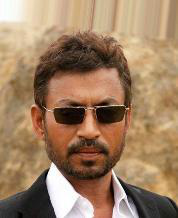

In [7]:
X = Image.open(os.path.join('./data', 'celeba', "img_align_celeba", '048318.jpg'))
X

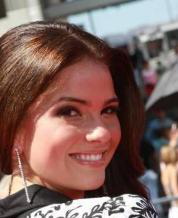

In [8]:
Image.open(os.path.join('./data', 'celeba', "img_align_celeba", '092372.jpg'))

In [9]:
######################################################
# SET SEED HERE -- that way we can ensure same dataset
######################################################
set_all_seeds(RANDOM_SEED)

In [10]:
# https://stackoverflow.com/questions/70896841/error-downloading-celeba-dataset-using-torchvision
# http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html

custom_transforms = torchvision.transforms.Compose([
    torchvision.transforms.CenterCrop((128, 128)),
    torchvision.transforms.ToTensor(),
    #torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CelebA(root = 'data',
                                split = 'train',
                                transform = custom_transforms)
# TAKE HALF OF THE IMAGES FOR TRAIN
train_indices = np.random.choice(range(len(train_dataset)), size=(int(len(train_dataset)/2),), replace=False)
train_indices = torch.tensor(train_indices)
train_sampler = SubsetRandomSampler(train_indices)
train_loader = DataLoader(dataset=train_dataset,
                          batch_size = BATCH_SIZE,
                          sampler=train_sampler,
                          num_workers = 2)


valid_dataset = datasets.CelebA(root='data',
                                split='valid',
                                transform=custom_transforms)
# TAKE HALF OF THE IMAGES FOR VALID
valid_indices = np.random.choice(range(len(valid_dataset)), size=(int(len(valid_dataset)/2),), replace=False)
valid_indices = torch.tensor(valid_indices)
valid_sampler = SubsetRandomSampler(valid_indices)
valid_loader = DataLoader(dataset=valid_dataset,
                         batch_size=BATCH_SIZE,
                         sampler=valid_sampler,
                         num_workers = 2)



# TAKE ANOTHER RANDOM HALF OF THE IMAGES FOR TRAIN
perf_indices = np.random.choice(range(len(train_dataset)), size=(int(len(train_dataset)/2),), replace=False)
perf_indices = torch.tensor(perf_indices)
perf_sampler = SubsetRandomSampler(perf_indices)
perf_loader = DataLoader(dataset=train_dataset,
                         batch_size = 512, # BIGGER BATCH TO SAMPLE FROM. NOT TOO BIG OR FREEZES
                         sampler=perf_sampler,
                         num_workers = 2)

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/torchvision/datasets/celeba.py:106: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  self.attr = (self.attr + 1) // 2  # map from {-1, 1} to {0, 1}
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/torchvision/datasets/celeba.py:106: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').

In [11]:
iter_ds = iter(valid_loader)
# next(iter_ds)

In [12]:
# Checking the dataset
print('Training Set:\n')
for images, labels in train_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    #print(labels[:10])
    break
  
    
"""Targets are 40-dim vectors representing
00 - 5_o_Clock_Shadow
01 - Arched_Eyebrows
02 - Attractive 
03 - Bags_Under_Eyes
04 - Bald
05 - Bangs
06 - Big_Lips
07 - Big_Nose
08 - Black_Hair
09 - Blond_Hair
10 - Blurry 
11 - Brown_Hair 
12 - Bushy_Eyebrows 
13 - Chubby 
14 - Double_Chin 
15 - Eyeglasses 
16 - Goatee 
17 - Gray_Hair 
18 - Heavy_Makeup 
19 - High_Cheekbones 
20 - Male 
21 - Mouth_Slightly_Open 
22 - Mustache 
23 - Narrow_Eyes 
24 - No_Beard 
25 - Oval_Face 
26 - Pale_Skin 
27 - Pointy_Nose 
28 - Receding_Hairline 
29 - Rosy_Cheeks 
30 - Sideburns 
31 - Smiling 
32 - Straight_Hair 
33 - Wavy_Hair 
34 - Wearing_Earrings 
35 - Wearing_Hat 
36 - Wearing_Lipstick 
37 - Wearing_Necklace 
38 - Wearing_Necktie 
39 - Young         
"""

Training Set:

Image batch dimensions: torch.Size([256, 3, 128, 128])
Image label dimensions: torch.Size([256, 40])


'Targets are 40-dim vectors representing\n00 - 5_o_Clock_Shadow\n01 - Arched_Eyebrows\n02 - Attractive \n03 - Bags_Under_Eyes\n04 - Bald\n05 - Bangs\n06 - Big_Lips\n07 - Big_Nose\n08 - Black_Hair\n09 - Blond_Hair\n10 - Blurry \n11 - Brown_Hair \n12 - Bushy_Eyebrows \n13 - Chubby \n14 - Double_Chin \n15 - Eyeglasses \n16 - Goatee \n17 - Gray_Hair \n18 - Heavy_Makeup \n19 - High_Cheekbones \n20 - Male \n21 - Mouth_Slightly_Open \n22 - Mustache \n23 - Narrow_Eyes \n24 - No_Beard \n25 - Oval_Face \n26 - Pale_Skin \n27 - Pointy_Nose \n28 - Receding_Hairline \n29 - Rosy_Cheeks \n30 - Sideburns \n31 - Smiling \n32 - Straight_Hair \n33 - Wavy_Hair \n34 - Wearing_Earrings \n35 - Wearing_Hat \n36 - Wearing_Lipstick \n37 - Wearing_Necklace \n38 - Wearing_Necktie \n39 - Young         \n'

<br>

## VAE Model Structure

In [13]:
####################################################
### LET OUR VAE model have R256 latent space
####################################################


class Reshape(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)


class Trim(nn.Module):
    def __init__(self, *args):
        super().__init__()

    def forward(self, x):
        return x[:, :, :128, :128]

# https://discuss.pytorch.org/t/runtimeerror-running-mean-should-contain-64-elements-not-96/30846
# DISCUSS BATCHNORM2D
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
                nn.Conv2d(3, 16, stride=2, kernel_size=3, bias=False, padding=1),
                nn.BatchNorm2d(16),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.Conv2d(16, 16, stride=2, kernel_size=3, bias=False, padding=1),
                nn.BatchNorm2d(16),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.Conv2d(16, 32, stride=2, kernel_size=3, bias=False, padding=1),
                nn.BatchNorm2d(32),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.Conv2d(32, 32, stride=2, kernel_size=3, bias=False, padding=1),
                nn.BatchNorm2d(32),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.Flatten(),
        )    
        
        self.z_mean = torch.nn.Linear(2048, 128)
        self.z_log_var = torch.nn.Linear(2048, 128)
        
        self.decoder = nn.Sequential(
                torch.nn.Linear(128, 2048),
                Reshape(-1, 32, 8, 8),
                #
                nn.ConvTranspose2d(32, 32, stride=2, kernel_size=3),
                nn.BatchNorm2d(32),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.ConvTranspose2d(32, 16, stride=2, kernel_size=3, padding=1),
                nn.BatchNorm2d(16),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.ConvTranspose2d(16, 16, stride=2, kernel_size=3, padding=1),
                nn.BatchNorm2d(16),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.ConvTranspose2d(16, 3, stride=2, kernel_size=3, padding=1),
                #
                Trim(),  # 3x129x129 -> 3x128x128
                nn.Sigmoid()
                )


    def encoding_fn(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        return encoded

        
    def reparameterize(self, z_mu, z_log_var):
#         eps = torch.randn(z_mu.size(0), z_mu.size(1)).to(z_mu.get_device()) # .get_device() DOES NOT WORK. ASSUME CPU
        eps = torch.randn(z_mu.size(0), z_mu.size(1)).to('cpu') 
        z = z_mu + eps * torch.exp(z_log_var/2.) 
        return z
        
    def forward(self, x):
        x = self.encoder(x)
#         print(x.shape)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        decoded = self.decoder(encoded)
#         return x
        return encoded, z_mean, z_log_var, decoded


<br>

## Training

In [45]:
vae_model = VAE()
vae_model.to(DEVICE)

In [17]:
# RELOAD THE MODEL
PATH = './Model Files/vae_celeba_v1_epoch_21.pt'

vae_model = VAE() # LOAD FROM ABOVE FIRST IF NEEDED
vae_model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [18]:
optimizer = torch.optim.Adam(vae_model.parameters(), lr=LEARNING_RATE)  

In [19]:
# for batch_idx, (features, _) in enumerate(train_loader):
#     features = features # ALREADY ON CPU?
#     # FORWARD AND BACK PROP
#     encoded, z_mean, z_log_var, decoded = vae_model(features)
    
#     break

In [ ]:
loss_fn = F.mse_loss
logging_interval=50
skip_epoch_stats=True
NUM_EPOCHS = 28 # TAKES TOO LONG TO RUN . CONSIDER USING DATABRICKS? ALSO STEPWISE EPOCHS TRAINING TO OBSERVE
reconstruction_term_weight=1
DEVICE = DEVICE

log_dict_vae = {'train_combined_loss_per_batch': [],
                'train_combined_loss_per_epoch': [],
                'train_reconstruction_loss_per_batch': [],
                'train_kl_loss_per_batch': []}


start_time = time.time()
for epoch in range(21, NUM_EPOCHS): # TAKES TOO LONG TO RUN . CONSIDER USING DATABRICKS? ALSO STEPWISE EPOCHS TRAINING TO OBSERVE

    vae_model.train()
    for batch_idx, (features, _) in enumerate(train_loader):

        features = features

        # FORWARD AND BACK PROP
        encoded, z_mean, z_log_var, decoded = vae_model(features)

        # total loss = reconstruction loss + KL divergence
        #kl_divergence = (0.5 * (z_mean**2 + 
        #                        torch.exp(z_log_var) - z_log_var - 1)).sum()
        kl_div = -0.5 * torch.sum(1 + z_log_var 
                                  - z_mean**2 
                                  - torch.exp(z_log_var), 
                                  axis=1) # sum over latent dimension

        batchsize = kl_div.size(0)
        kl_div = kl_div.mean() # average over batch dimension

        pixelwise = loss_fn(decoded, features, reduction='none')
        pixelwise = pixelwise.view(batchsize, -1).sum(axis=1) # sum over pixels
        pixelwise = pixelwise.mean() # average over batch dimension

        loss = reconstruction_term_weight*pixelwise + kl_div

        optimizer.zero_grad()

        loss.backward()

        # UPDATE VAE MODEL PARAMETERS
        optimizer.step()

        # LOGGING
        log_dict_vae['train_combined_loss_per_batch'].append(loss.item())
        log_dict_vae['train_reconstruction_loss_per_batch'].append(pixelwise.item())
        log_dict_vae['train_kl_loss_per_batch'].append(kl_div.item())

        if not batch_idx % logging_interval:
            print('Epoch: %03d/%03d | Batch %04d/%04d | Loss: %.4f'
                  % (epoch+1, NUM_EPOCHS, batch_idx,
                      len(train_loader), loss))
            print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
        
    if not skip_epoch_stats:
        vae_model.eval()

        with torch.set_grad_enabled(False):  # save memory during inference

            train_loss = compute_epoch_loss_VAE(
                vae_model, train_loader, loss_fn, DEVICE)
            print('***Epoch: %03d/%03d | Loss: %.3f' % (
                  epoch+1, NUM_EPOCHS, train_loss))
            log_dict_vae['train_combined_loss_per_epoch'].append(train_loss.item())

    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
    # SAVE INTERMEDIATE VAE models to see our training progress. Epoch 1, Epoch Half, Epoch Final
    if np.isin(epoch + 1, [1, int(NUM_EPOCHS/2), NUM_EPOCHS]) == True:
        mdl_name = './Model Files/vae_celeba_v1_epoch_'+ str(epoch+1) + '.pt'
        # https://stackoverflow.com/questions/59095824/what-is-the-difference-between-pt-pth-and-pwf-extentions-in-pytorch
        torch.save(vae_model.state_dict(), mdl_name)

print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 022/028 | Batch 0000/0318 | Loss: 777.0507
Time elapsed: 0.21 min
Epoch: 022/028 | Batch 0050/0318 | Loss: 744.7645
Time elapsed: 4.98 min
Epoch: 022/028 | Batch 0100/0318 | Loss: 751.5911
Time elapsed: 9.83 min
Epoch: 022/028 | Batch 0150/0318 | Loss: 752.2262
Time elapsed: 14.70 min
Epoch: 022/028 | Batch 0200/0318 | Loss: 750.4850
Time elapsed: 19.56 min
Epoch: 022/028 | Batch 0250/0318 | Loss: 752.1169
Time elapsed: 24.46 min
Epoch: 022/028 | Batch 0300/0318 | Loss: 742.1610
Time elapsed: 29.38 min
Time elapsed: 30.89 min
Epoch: 023/028 | Batch 0000/0318 | Loss: 780.8655
Time elapsed: 31.12 min
Epoch: 023/028 | Batch 0050/0318 | Loss: 751.2339
Time elapsed: 35.98 min
Epoch: 023/028 | Batch 0100/0318 | Loss: 756.3860
Time elapsed: 40.89 min
Epoch: 023/028 | Batch 0150/0318 | Loss: 774.1436
Time elapsed: 45.76 min
Epoch: 023/028 | Batch 0200/0318 | Loss: 747.2563
Time elapsed: 50.64 min
Epoch: 023/028 | Batch 0250/0318 | Loss: 759.3253
Time elapsed: 55.52 min
Epoch: 023/028 | 

## Evaluation

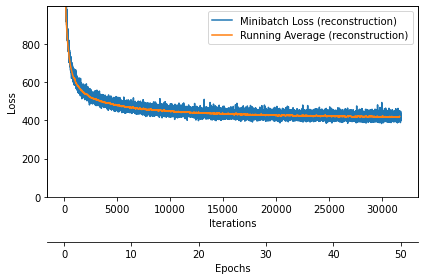

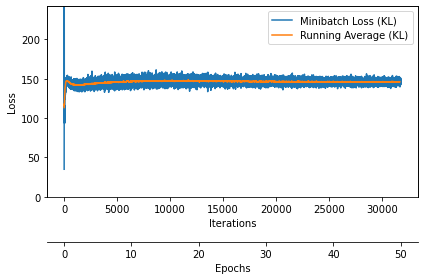

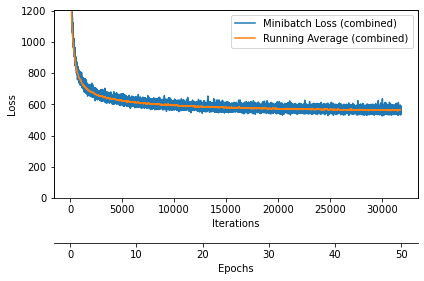

In [11]:
plot_training_loss(log_dict['train_reconstruction_loss_per_batch'], NUM_EPOCHS, custom_label=" (reconstruction)")
plot_training_loss(log_dict['train_kl_loss_per_batch'], NUM_EPOCHS, custom_label=" (KL)")
plot_training_loss(log_dict['train_combined_loss_per_batch'], NUM_EPOCHS, custom_label=" (combined)")
plt.show()

<br>

## Deeper Look at the Faces

In [14]:
PATH = './Model Files/vae_celeba_v1_epoch_21.pt'

vae_model = VAE() # LOAD FROM ABOVE FIRST IF NEEDED
vae_model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

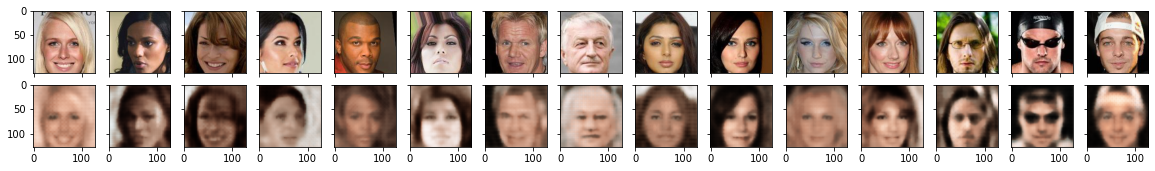

In [15]:
######################################################
# Generate faces at random from the train loader
# See how well they match up with original
# Run this a few times to see
######################################################

plot_generated_images(data_loader=train_loader,
                      model=vae_model,
                      #unnormalizer=unnormalizer,
                      device=DEVICE,
                      modeltype='VAE')           

In [16]:
######################################################
# Generate specific type of face from train loader
# See how well they match up with original
# Run below lines a few times to see results changing
######################################################

In [17]:
iterer_perf_loader = iter(perf_loader)

In [18]:
# CAN RUN THIS LINE UP TO 2 TIMES - but will take awhile each time 
iter_perf = next(iterer_perf_loader)

In [19]:
######################################################
# Let's look at smiling females as an example
######################################################

# 31 - Smiling 
# 20 - Male

feature_vec = torch.empty(0)
tgt_vec = torch.empty(0)

n_images = 10

faces_want = torch.from_numpy(np.where((iter_perf[1][:,31] == 1) & (iter_perf[1][:,20] == 0))[0])
feature_want = iter_perf[0][faces_want,:,:,:]
tgt_want = iter_perf[1][faces_want,:]
print('Number of faces satisfying this requirement: '+  str(feature_want.shape))

feature_vec = torch.cat((feature_vec, feature_want), dim = 0)
tgt_vec = torch.cat((tgt_vec, tgt_want), dim = 0)

encoded, z_mean, z_log_var, decoded_images = vae_model(feature_vec)
samp_imgs = torch.from_numpy(np.random.choice(len(feature_vec),10))

fin_decoded_images = decoded_images[samp_imgs,:,:,:]
fin_orig_images = feature_vec[samp_imgs,:,:,:]

Number of faces satisfying this requirement: torch.Size([147, 3, 128, 128])


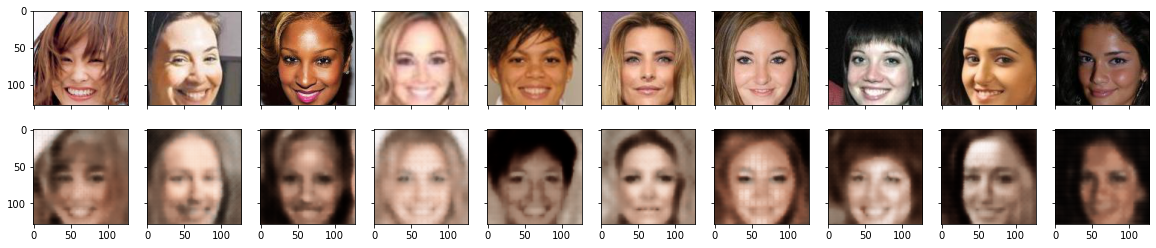

In [20]:
plot_only_real_gen(fin_orig_images, fin_decoded_images, n_images = n_images, figsize=(20, 4))

<br>

In [21]:
######################################################
# Generate new faces randomly from the entire Latent Distribution
######################################################

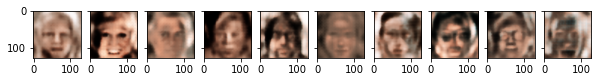

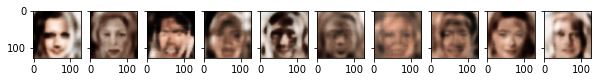

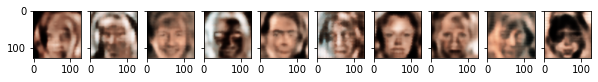

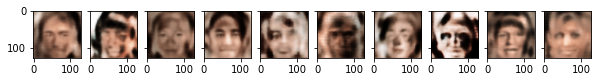

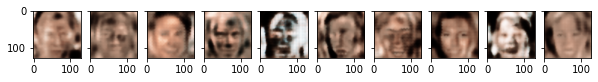

In [27]:
# MAKE SURE TO CHANGE LATENT SIZE AS NEEDED
for i in range(5):
    plot_images_sampled_from_vae(model=vae_model, device=DEVICE, latent_size=128)
    plt.show()

<br>

In [32]:
######################################################
# Generate a specific type of faces from latent distribution
######################################################

In [48]:
feature_vec = torch.empty(0)
tgt_vec = torch.empty(0)

In [49]:
######################################################
# Old Males
######################################################

# 39 - Young
# 20 - Male 
# 02 - Attractive 

n_images = 10

faces_want = torch.from_numpy(np.where((iter_perf[1][:,39] == 0) & (iter_perf[1][:,20] == 1))[0])
feature_want = iter_perf[0][faces_want,:,:,:]
tgt_want = iter_perf[1][faces_want,:]

feature_vec = torch.cat((feature_vec, feature_want), dim = 0)
tgt_vec = torch.cat((tgt_vec, tgt_want), dim = 0)

encoded, z_mean, z_log_var, decoded_images = vae_model(feature_vec)
print('Using the following dimension size to produce generate faces: '+  str(feature_vec.shape))

Using the following dimension size to produce generate faces: torch.Size([87, 3, 128, 128])


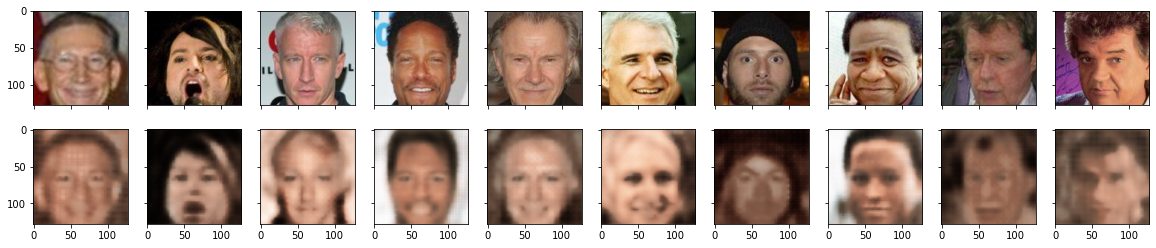

In [50]:
samp_imgs = torch.from_numpy(np.random.choice(len(feature_vec),n_images))
fin_decoded_images = decoded_images[samp_imgs,:,:,:]
fin_orig_images = feature_vec[samp_imgs,:,:,:]

plot_only_real_gen(fin_orig_images, fin_decoded_images, n_images = n_images, figsize=(20, 4))

In [51]:
# Get the MEAN of the z_means. This way we generate from ONE mean
meanmean = torch.mean(z_mean, dim = 0)
# Get the SD of the mean of the exp(log_vars) (aka sqrt(mean(exp(z_logvar))))
meansd = torch.sqrt(torch.mean(torch.exp(z_log_var), dim = 0))

# Generate a bunch of obs of Z ~ N(0,1), where  
eps = torch.randn(100, meanmean.size(0)).to('cpu')
# Generate X ~ u + sig*Z
newgen_imgs = meanmean + eps * meansd
# Decode the images with our model
decoded_images = vae_model.decoder(newgen_imgs)
# We only want to plot plot how many images
print('Generated ' + str(decoded_images.shape) + ' new observations')

Generated torch.Size([100, 3, 128, 128]) new observations


In [45]:
######################################################
# Generate some brand new faces based on selected type
# Run below lines a few times to see results changing
######################################################

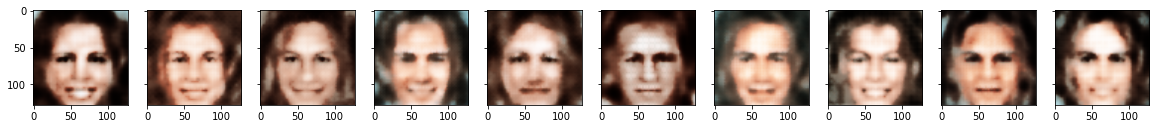

In [52]:
samp_imgs = torch.from_numpy(np.random.choice(len(decoded_images), n_images))
gen_decoded_images = decoded_images[samp_imgs,:,:,:]

plot_only_gen(gen_decoded_images, n_images = 10)

<br>

<br>

## What Else Can We Do?

In [53]:
######################################################
# Can we try to transform a face into another face?
######################################################

In [ ]:
# # TAKE HALF OF THE IMAGES FOR TRAIN
# # TAKES TOO LONG TO GET LIVE
# train_smallidx = np.random.choice(range(len(train_dataset)), 20000, replace=False)
# train_smallidx = torch.tensor(train_smallidx)
# train_sampler = SubsetRandomSampler(train_smallidx)
# train_loader_small = DataLoader(dataset=train_dataset,
#                                 batch_size = 50, # SMALLER FASTER?
#                                 sampler=train_sampler,
#                                 num_workers = 2)

In [ ]:
# time_st = time.time()
# avg_img_with_feat, avg_img_without_feat = compute_average_faces(
#     feature_idx=31, # smiling
#     image_dim=128,
#     data_loader=train_loader_small,
#     device=DEVICE,
#     encoding_fn=vae_model.encoding_fn)
# print(time.time() - time_st)

# with open('./Model Files/avg_smiling.npy', 'wb') as f:
#     np.save(f, avg_img_with_feat.numpy())
#     np.save(f, avg_img_without_feat.numpy())

In [23]:
with open('./Model Files/avg_smiling.npy', 'rb') as f:
    avg_img_with_feat = np.load(f)
    avg_img_without_feat = np.load(f)

avg_img_with_feat = torch.tensor(avg_img_with_feat)
avg_img_without_feat = torch.tensor(avg_img_without_feat)

<br>

In [57]:
######################################
# Decode the images with our model
######################################

In [24]:
decoded_smile = vae_model.decoder(avg_img_with_feat)
decoded_frown = vae_model.decoder(avg_img_without_feat)

In [25]:
decoded_smile = decoded_smile[0,:,:,:].detach().to(torch.device('cpu'))
decoded_smile = np.transpose(decoded_smile, (1, 2, 0))

decoded_frown = decoded_frown[0,:,:,:].detach().to(torch.device('cpu'))
decoded_frown = np.transpose(decoded_frown, (1, 2, 0))

ls_decoded = [decoded_smile, decoded_frown]

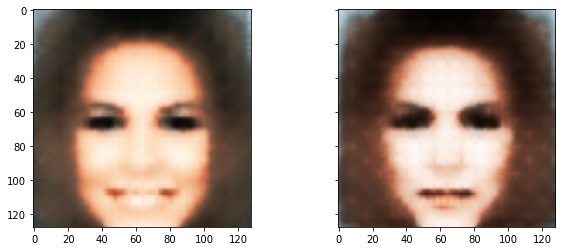

In [27]:
fig, axes = plt.subplots(nrows=1, ncols=2, 
                         sharex=True, sharey=True, figsize=(10, 4))

for i, ax in enumerate(axes):
    curr_img = ls_decoded[i]
    ax.imshow(curr_img)

<br>

In [471]:
#################################################
# Can we make Matt look sad that he's leaving?
#################################################

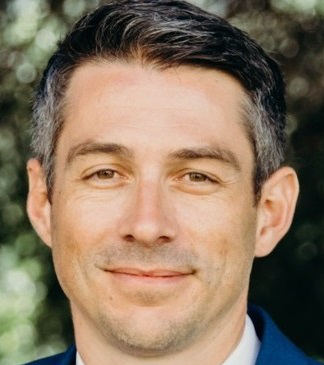

In [28]:
pic_matt = Image.open(os.path.join('./Model Files', 'pic_matt_2.jpg'))
pic_matt

In [29]:
pic_matt.size

(324, 365)

In [30]:
left = 0
top = 5
right = 324
bottom = 329
pic_matt = pic_matt.crop((left, top, right, bottom))
print(pic_matt.size)

(324, 324)


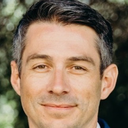

In [31]:
size = 128, 128
pic_matt.thumbnail(size, Image.ANTIALIAS)
pic_matt

In [32]:
tensor_matt = transforms.ToTensor()(pic_matt).unsqueeze(0) 
tensor_matt.shape

torch.Size([1, 3, 128, 128])

In [33]:
# Decode the images with our model
encoded_diff = avg_img_with_feat - avg_img_without_feat

decoded_smile = vae_model.decoder(avg_img_with_feat)
decoded_frown = vae_model.decoder(avg_img_without_feat)
decoded_diff = (decoded_smile - decoded_frown)

In [34]:
decoded_diff.squeeze().permute(1, 2, 0).shape

torch.Size([128, 128, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

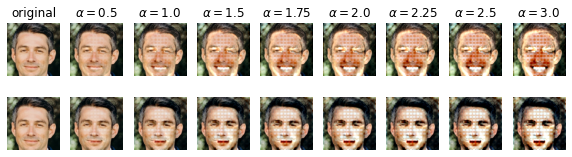

In [35]:
##################################################
#### NOT A REAL DEEPFAKE PLOT
##################################################

plot_modified_faces_v2(original=tensor_matt, diff=decoded_diff, 
                       diff_coefficients=(0., 0.5, 1., 1.5, 1.75, 2., 2.25, 2.5, 3.),
                       figsize = (10, 2.5))

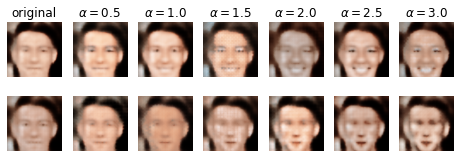

In [36]:
##################################################
#### BUT THE DEEPFAKE DOESNT LOOK AS GOOD
##################################################
plot_modified_faces(original=vae_model.encoding_fn(tensor_matt), diff=encoded_diff,
                    diff_coefficients=(0., 0.5, 1., 1.5, 2., 2.5, 3.),
                    decoding_fn=vae_model.decoder,
                    device=None,
                    figsize=(8, 2.5))

<br>

In [88]:
#################################################
# Is everyone able to be made sad?
#################################################

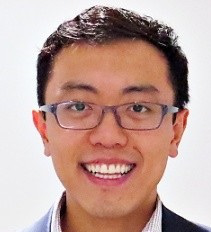

In [37]:
pic_adam = Image.open(os.path.join('./Model Files', 'pic_adam_2.jpg'))
pic_adam

In [38]:
pic_adam.size

(211, 232)

In [39]:
left = 0
top = 1
right = 211
bottom = 212
pic_adam = pic_adam.crop((left, top, right, bottom))
print(pic_adam.size)

(211, 211)


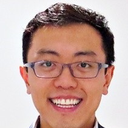

In [40]:
size = 128, 128
pic_adam.thumbnail(size, Image.ANTIALIAS)
pic_adam

In [41]:
tensor_adam = transforms.ToTensor()(pic_adam).unsqueeze(0)

In [42]:
# Decode the images with our model
encoded_diff = avg_img_with_feat - avg_img_without_feat

decoded_smile = vae_model.decoder(avg_img_with_feat)
decoded_frown = vae_model.decoder(avg_img_without_feat)
decoded_diff = (decoded_smile - decoded_frown)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

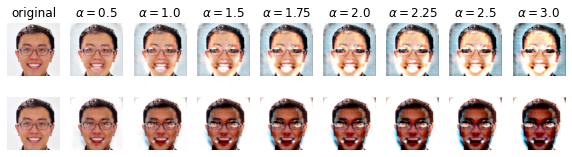

In [43]:
plot_modified_faces_v2(original=tensor_adam, diff=decoded_diff, 
                       diff_coefficients=(0., 0.5, 1., 1.5, 1.75, 2., 2.25, 2.5, 3.),
                       figsize = (10, 2.5))

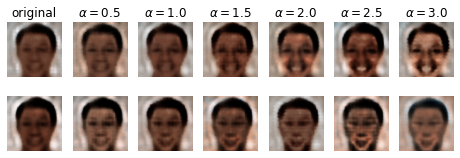

In [44]:
plot_modified_faces(original=vae_model.encoding_fn(tensor_adam), diff=encoded_diff,
                    diff_coefficients=(0., 0.5, 1., 1.5, 2., 2.5, 3.),
                    decoding_fn=vae_model.decoder,
                    device=None,
                    figsize=(8, 2.5))